## Connecting to Spark and HDFS. Went through the tutoral in hope of finding images of flowers, but unsuccessful with this. Will try another method. 

In [1]:
%%capture
!pip install import_ipynb

# import the jupyter notebook importer
import import_ipynb
from data603 import SparkLauncher
from data603 import HDFS

spark = SparkLauncher.get_spark_session(pack_venv = False)
hdfs = HDFS.get_hdfs()

# Examine Metadata

In [2]:
hdfs.ls('/data/google_open_image')

['/data/google_open_image/bboxes',
 '/data/google_open_image/ids',
 '/data/google_open_image/images',
 '/data/google_open_image/labels',
 '/data/google_open_image/masks',
 '/data/google_open_image/metadata',
 '/data/google_open_image/relationships',
 '/data/google_open_image/segmentations']

## Examine the Bounding Box Data

In [3]:
hdfs.ls('/data/google_open_image/bboxes')

['/data/google_open_image/bboxes/test-annotations-bbox.csv',
 '/data/google_open_image/bboxes/train-annotations-bbox.csv',
 '/data/google_open_image/bboxes/validation-annotations-bbox.csv']

## Read the CSV with Spark

### `spark.read.csv()` `take(n)` 

In [4]:
bounding_boxes = spark.read.csv('/data/google_open_image/bboxes/test-annotations-bbox.csv', header = True)

In [5]:
# Grab 5 entries
bounding_boxes.take(5)

[Row(ImageID='000026e7ee790996', Source='xclick', LabelName='/m/07j7r', Confidence='1', XMin='0.071875', XMax='0.1453125', YMin='0.20625', YMax='0.39166668', IsOccluded='0', IsTruncated='1', IsGroupOf='1', IsDepiction='0', IsInside='0'),
 Row(ImageID='000026e7ee790996', Source='xclick', LabelName='/m/07j7r', Confidence='1', XMin='0.4390625', XMax='0.571875', YMin='0.26458332', YMax='0.43541667', IsOccluded='0', IsTruncated='1', IsGroupOf='1', IsDepiction='0', IsInside='0'),
 Row(ImageID='000026e7ee790996', Source='xclick', LabelName='/m/07j7r', Confidence='1', XMin='0.66875', XMax='1', YMin='0', YMax='0.5520833', IsOccluded='0', IsTruncated='1', IsGroupOf='1', IsDepiction='0', IsInside='0'),
 Row(ImageID='000062a39995e348', Source='xclick', LabelName='/m/015p6', Confidence='1', XMin='0.20620842', XMax='0.849224', YMin='0.15463917', YMax='1', IsOccluded='0', IsTruncated='0', IsGroupOf='0', IsDepiction='0', IsInside='0'),
 Row(ImageID='000062a39995e348', Source='xclick', LabelName='/m/05

## That's Ugly, Use `show()` Instead

In [6]:
bounding_boxes.show(5)

+----------------+------+---------+----------+----------+----------+----------+----------+----------+-----------+---------+-----------+--------+
|         ImageID|Source|LabelName|Confidence|      XMin|      XMax|      YMin|      YMax|IsOccluded|IsTruncated|IsGroupOf|IsDepiction|IsInside|
+----------------+------+---------+----------+----------+----------+----------+----------+----------+-----------+---------+-----------+--------+
|000026e7ee790996|xclick| /m/07j7r|         1|  0.071875| 0.1453125|   0.20625|0.39166668|         0|          1|        1|          0|       0|
|000026e7ee790996|xclick| /m/07j7r|         1| 0.4390625|  0.571875|0.26458332|0.43541667|         0|          1|        1|          0|       0|
|000026e7ee790996|xclick| /m/07j7r|         1|   0.66875|         1|         0| 0.5520833|         0|          1|        1|          0|       0|
|000062a39995e348|xclick| /m/015p6|         1|0.20620842|  0.849224|0.15463917|         1|         0|          0|        0|       

## That Was Better, but view as Pandas instead

### `select()` `limit()` `toPandas()`


In [7]:
# !!! bounding_boxes.toPandas() would work until it crashed your system
#     be sure to limit results when converting to local data frame.
bb_pd = bounding_boxes.select("*").limit(10)
bb_pd.toPandas()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000026e7ee790996,xclick,/m/07j7r,1,0.071875,0.1453125,0.20625,0.39166668,0,1,1,0,0
1,000026e7ee790996,xclick,/m/07j7r,1,0.4390625,0.571875,0.26458332,0.43541667,0,1,1,0,0
2,000026e7ee790996,xclick,/m/07j7r,1,0.66875,1,0,0.5520833,0,1,1,0,0
3,000062a39995e348,xclick,/m/015p6,1,0.20620842,0.849224,0.15463917,1,0,0,0,0,0
4,000062a39995e348,xclick,/m/05s2s,1,0.13747229,0.37694013,0,0.88365245,1,1,0,0,0
5,0000c64e1253d68f,xclick,/m/0k4j,1,0,0.5132743,0.32079646,0.6902655,0,1,0,0,0
6,0000c64e1253d68f,xclick,/m/0k4j,1,0.016224189,0.26843658,0.29867256,0.46238938,1,0,0,0,0
7,0000c64e1253d68f,xclick,/m/0k4j,1,0.48082596,0.9041298,0.23230088,0.48893806,1,0,0,0,0
8,0000c64e1253d68f,xclick,/m/0k4j,1,0.7522124,1,0.3318584,0.65707964,0,1,0,0,0
9,0000c64e1253d68f,xclick,/m/07yv9,1,0,0.9734513,0,0.044247787,0,1,1,0,0


## Let's look at the Schema Spark Assigned

### `printSchema()`

In [8]:
#Look at the schema it was assiignmed. it calls everything a string. cant do much
bounding_boxes.printSchema()

root
 |-- ImageID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- LabelName: string (nullable = true)
 |-- Confidence: string (nullable = true)
 |-- XMin: string (nullable = true)
 |-- XMax: string (nullable = true)
 |-- YMin: string (nullable = true)
 |-- YMax: string (nullable = true)
 |-- IsOccluded: string (nullable = true)
 |-- IsTruncated: string (nullable = true)
 |-- IsGroupOf: string (nullable = true)
 |-- IsDepiction: string (nullable = true)
 |-- IsInside: string (nullable = true)



# Read CSVs into 3 Separate Dataframes

### `spark.read.csv()`

In [9]:
#read files into to different dataframes
bb_test = spark.read.csv('/data/google_open_image/bboxes/test-annotations-bbox.csv', header = True)
bb_train = spark.read.csv('/data/google_open_image/bboxes/train-annotations-bbox.csv', header = True)
bb_validation = spark.read.csv('/data/google_open_image/bboxes/validation-annotations-bbox.csv', header = True)

## Create new Column "Subset" to Track Source File

### `withColumn()` `functions.lit()`

In [10]:
#withcolumn add new col to new dataframe. 
from pyspark.sql.functions import lit  # lit stands for "literal"

bb_test = bb_test.withColumn("Subset", lit("test"))#add back to dataframe
bb_train = bb_train.withColumn("Subset", lit("train"))
bb_validation = bb_validation.withColumn("Subset", lit("validation"))

## Union the 3 dataframes together

### `union()`

In [11]:
bounding_boxes = bb_test.union(bb_train).union(bb_validation)

## Validate Everything Unioned Correctly

### `count()`

In [12]:
bb_test.count() + bb_validation.count() + bb_train.count()

15851536

In [13]:
bounding_boxes.count() #compare to final to make number of rows should be the same 

15851536

# Back to Schemas

In [14]:
bounding_boxes.printSchema()

root
 |-- ImageID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- LabelName: string (nullable = true)
 |-- Confidence: string (nullable = true)
 |-- XMin: string (nullable = true)
 |-- XMax: string (nullable = true)
 |-- YMin: string (nullable = true)
 |-- YMax: string (nullable = true)
 |-- IsOccluded: string (nullable = true)
 |-- IsTruncated: string (nullable = true)
 |-- IsGroupOf: string (nullable = true)
 |-- IsDepiction: string (nullable = true)
 |-- IsInside: string (nullable = true)
 |-- Subset: string (nullable = false)



Everything is Still a String

## Convert Columns To Desired DataTypes
### `withColumn` `cast` `DoubleType`

In [15]:
from pyspark.sql.types import DoubleType
#name of numer col with old name & replace it. cast it to a double

bounding_boxes = bounding_boxes.withColumn("XMin", bounding_boxes['XMin'].cast(DoubleType()))
bounding_boxes = bounding_boxes.withColumn("XMax", bounding_boxes['XMax'].cast(DoubleType()))
bounding_boxes = bounding_boxes.withColumn("YMin", bounding_boxes['YMin'].cast(DoubleType()))
bounding_boxes = bounding_boxes.withColumn("YMax", bounding_boxes['YMax'].cast(DoubleType()))
bounding_boxes = bounding_boxes.withColumn("Confidence", bounding_boxes['Confidence'].cast(DoubleType()))

## Use a Loop To Set Boolean Columns
### `when` `withColumn`

In [16]:
import pyspark.sql.functions as F
#change to bool values this is done in a loop
cols = ["IsOccluded", "IsTruncated", "IsGroupOf", "IsDepiction", "IsInside"]
for index in cols:
    bounding_boxes = bounding_boxes.withColumn(
        index, 
        F.when(
            F.col(index) == '1', #function in spark.spl for col
            True
        ).when(
            F.col(index) == '0',
            False
        )
    )


## Check Schema Now

In [17]:
bounding_boxes.printSchema()

root
 |-- ImageID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- LabelName: string (nullable = true)
 |-- Confidence: double (nullable = true)
 |-- XMin: double (nullable = true)
 |-- XMax: double (nullable = true)
 |-- YMin: double (nullable = true)
 |-- YMax: double (nullable = true)
 |-- IsOccluded: boolean (nullable = true)
 |-- IsTruncated: boolean (nullable = true)
 |-- IsGroupOf: boolean (nullable = true)
 |-- IsDepiction: boolean (nullable = true)
 |-- IsInside: boolean (nullable = true)
 |-- Subset: string (nullable = false)



## Examine Data Now

In [18]:
bounding_boxes.select("*").limit(10).toPandas()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,Subset
0,000026e7ee790996,xclick,/m/07j7r,1.0,0.071875,0.145313,0.206250,0.391667,False,True,True,False,False,test
1,000026e7ee790996,xclick,/m/07j7r,1.0,0.439063,0.571875,0.264583,0.435417,False,True,True,False,False,test
2,000026e7ee790996,xclick,/m/07j7r,1.0,0.668750,1.000000,0.000000,0.552083,False,True,True,False,False,test
3,000062a39995e348,xclick,/m/015p6,1.0,0.206208,0.849224,0.154639,1.000000,False,False,False,False,False,test
4,000062a39995e348,xclick,/m/05s2s,1.0,0.137472,0.376940,0.000000,0.883652,True,True,False,False,False,test
5,0000c64e1253d68f,xclick,/m/0k4j,1.0,0.000000,0.513274,0.320796,0.690265,False,True,False,False,False,test
6,0000c64e1253d68f,xclick,/m/0k4j,1.0,0.016224,0.268437,0.298673,0.462389,True,False,False,False,False,test
7,0000c64e1253d68f,xclick,/m/0k4j,1.0,0.480826,0.904130,0.232301,0.488938,True,False,False,False,False,test
8,0000c64e1253d68f,xclick,/m/0k4j,1.0,0.752212,1.000000,0.331858,0.657080,False,True,False,False,False,test
9,0000c64e1253d68f,xclick,/m/07yv9,1.0,0.000000,0.973451,0.000000,0.044248,False,True,True,False,False,test


## Investigate the Source Field
### `select` `distinct`

In [19]:
#exaime the source label in the bounding box frame. 
bounding_boxes.select("Source").distinct().show() 

+---------+
|   Source|
+---------+
|   xclick|
|activemil|
+---------+



There's two Different Sources, "xclick" and "activemil"

## Find Distribution of Source Among Subsets
### `groupby` `count`

In [20]:
#how important are they 
aa= bounding_boxes.groupby("Subset", "Source").count()
aa.show()

+----------+---------+--------+
|    Subset|   Source|   count|
+----------+---------+--------+
|     train|   xclick|13050532|
|      test|   xclick|  937327|
|     train|activemil| 1559697|
|validation|   xclick|  303980|
+----------+---------+--------+



only the "train" Subset contains "activemil" 

## Filter Out "activemil" Entries
### `filter`

In [21]:
# Note that filter is filter IN not filter OUT
bounding_xclick = bounding_boxes.filter("Source != 'activemil'")  # pay attention to quoting

In [22]:
bounding_xclick.groupby("Subset", "Source").count().show()

+----------+------+--------+
|    Subset|Source|   count|
+----------+------+--------+
|     train|xclick|13050532|
|      test|xclick|  937327|
|validation|xclick|  303980|
+----------+------+--------+



And they're gone!

# Examine the Image ID Files

In [23]:
hdfs.ls('/data/google_open_image/ids')

['/data/google_open_image/ids/test-images-with-rotation.csv',
 '/data/google_open_image/ids/train-images-boxable-with-rotation.csv',
 '/data/google_open_image/ids/validation-images-with-rotation.csv']

## Read the CSV

In [24]:
ids_validation = spark.read.csv('/data/google_open_image/ids/validation-images-with-rotation.csv', header = True)

In [25]:
ids_validation.printSchema()

root
 |-- ImageID: string (nullable = true)
 |-- Subset: string (nullable = true)
 |-- OriginalURL: string (nullable = true)
 |-- OriginalLandingURL: string (nullable = true)
 |-- License: string (nullable = true)
 |-- AuthorProfileURL: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- OriginalSize: string (nullable = true)
 |-- OriginalMD5: string (nullable = true)
 |-- Thumbnail300KURL: string (nullable = true)
 |-- Rotation: string (nullable = true)



OriginalSize and Rotation aren't strings, let's read it differently

## Define a Schema Up Front
### `pyspark.sql.types DoubleType StringType IntegerType StructType StructField`

In [26]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, StringType, IntegerType

ids_schema = StructType([
    StructField("ImageID", StringType()),
    StructField("Subset", StringType()),
    StructField("OriginalURL", StringType()),
    StructField("OriginalLandingURL", StringType()),
    StructField("License", StringType()),
    StructField("AuthorProfileURL", StringType()),
    StructField("Author", StringType()),
    StructField("Title", StringType()),
    StructField("OriginalSize", IntegerType()),
    StructField("OriginalMD5", StringType()),
    StructField("Thumbnail300KURL", StringType()),
    StructField("Rotation", DoubleType())
])

## Use Schema To Read the CSV

In [27]:
ids_validation_schema = spark.read\
                      .csv("/data/google_open_image/ids/validation-images-with-rotation.csv",
                           header = True,
                           schema = ids_schema)

In [28]:
ids_validation_schema.printSchema()

root
 |-- ImageID: string (nullable = true)
 |-- Subset: string (nullable = true)
 |-- OriginalURL: string (nullable = true)
 |-- OriginalLandingURL: string (nullable = true)
 |-- License: string (nullable = true)
 |-- AuthorProfileURL: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- OriginalSize: integer (nullable = true)
 |-- OriginalMD5: string (nullable = true)
 |-- Thumbnail300KURL: string (nullable = true)
 |-- Rotation: double (nullable = true)



Much Better!

## Check Versions To See if Same Number of Entries

In [29]:
ids_validation.count()

41620

In [30]:
ids_validation_schema.count()

41620

# Image Labels

## Read In Image Label CSVs

In [31]:
hdfs.ls('/data/google_open_image/labels')

['/data/google_open_image/labels/test-annotations-human-imagelabels-boxable.csv',
 '/data/google_open_image/labels/train-annotations-human-imagelabels-boxable.csv',
 '/data/google_open_image/labels/validation-annotations-human-imagelabels-boxable.csv']

In [32]:
label_schema = StructType([
    StructField("ImageID", StringType()),
    StructField("Source", StringType()),
    StructField("LabelName", StringType()),
    StructField("Confidence", DoubleType())
])

labels_validation = spark.read\
                         .csv('/data/google_open_image/labels/validation-annotations-human-imagelabels-boxable.csv', 
                              header = True,
                              schema = label_schema)

## Read in Class Descriptions Metadata

In [33]:
hdfs.ls('/data/google_open_image/metadata')

['/data/google_open_image/metadata/attributes-description.csv',
 '/data/google_open_image/metadata/class-descriptions-boxable.csv',
 '/data/google_open_image/metadata/classes-segmentation.txt',
 '/data/google_open_image/metadata/relationship-triplets.csv',
 '/data/google_open_image/metadata/relationships-description.csv']

In [34]:
# Schema can be defined inline, but probably not the best idea
labels = spark.read.csv('/data/google_open_image/metadata/class-descriptions-boxable.csv', 
                        schema = StructType([StructField("LabelName", StringType()), 
                                             StructField("LabelText", StringType())]) )

In [35]:
labels.show(5)

+-----------+----------+
|  LabelName| LabelText|
+-----------+----------+
|  /m/011k07|  Tortoise|
|/m/011q46kg| Container|
|  /m/012074|    Magpie|
|  /m/0120dh|Sea turtle|
|  /m/01226z|  Football|
+-----------+----------+
only showing top 5 rows



## Join Label Metadata With Validation Image Label Names
### `join()`

In [36]:
lbl_join = labels_validation.join(labels, on = 'LabelName', how = 'left')

In [37]:
#confience level are 1.0 or 0.0
lbl_join.show(10)

+---------+----------------+------------+----------+-----------------+
|LabelName|         ImageID|      Source|Confidence|        LabelText|
+---------+----------------+------------+----------+-----------------+
| /m/0cmf2|0001eeaf4aed83f9|verification|       1.0|         Airplane|
|/m/01g317|0004886b7d043cfd|verification|       0.0|           Person|
|/m/04hgtk|0004886b7d043cfd|verification|       0.0|       Human head|
| /m/09j2d|0004886b7d043cfd|verification|       0.0|         Clothing|
|/m/0463sg|0004886b7d043cfd|verification|       0.0|Fashion accessory|
| /m/07j7r|000595fe6fee6369|verification|       0.0|             Tree|
| /m/02xwb|000595fe6fee6369|verification|       1.0|            Fruit|
| /m/05s2s|000595fe6fee6369|verification|       0.0|            Plant|
|/m/0c9ph5|000595fe6fee6369|verification|       0.0|           Flower|
| /m/02wbm|000595fe6fee6369|verification|       1.0|             Food|
+---------+----------------+------------+----------+-----------------+
only s

Read the join() documentation for the various "how" methods

## Notice Some Confidence Values Were 0.0
### `where`  is same as `filter`

In [38]:
lbl_high_conf = lbl_join.where("Confidence > 0.99")
lbl_high_conf.show(10)

+----------+----------------+------------+----------+----------------+
| LabelName|         ImageID|      Source|Confidence|       LabelText|
+----------+----------------+------------+----------+----------------+
|  /m/0cmf2|0001eeaf4aed83f9|verification|       1.0|        Airplane|
|  /m/02xwb|000595fe6fee6369|verification|       1.0|           Fruit|
|  /m/02wbm|000595fe6fee6369|verification|       1.0|            Food|
|  /m/09j2d|00075905539074f2|verification|       1.0|        Clothing|
|  /m/04rky|00075905539074f2|verification|       1.0|          Mammal|
|/m/02p0tk3|00075905539074f2|verification|       1.0|      Human body|
| /m/05y5lj|00075905539074f2|verification|       1.0|Sports equipment|
|  /m/0dzf4|00075905539074f2|verification|       1.0|       Human arm|
|  /m/09j5n|00075905539074f2|verification|       1.0|        Footwear|
|  /m/04yx4|00075905539074f2|verification|       1.0|             Man|
+----------+----------------+------------+----------+----------------+
only s

## Find Some Images With More than One Label
### `agg` `countDistinct` `alias` `orderBy`

In [39]:
import pyspark.sql.functions as F
#groupby and aggeration with every one
ll = lbl_join.groupby("ImageID")\
              .agg(F.countDistinct("LabelText").alias("n_labels"))\
              .orderBy("n_labels", ascending = False)

In [40]:
ll.show(10)

+----------------+--------+
|         ImageID|n_labels|
+----------------+--------+
|c9beadfaec7b5043|      25|
|a52964795b0e2475|      25|
|bdb8487ccbb6d988|      25|
|9f8550843e6f1ba6|      24|
|8330ba335d902294|      24|
|935acc24545d071a|      24|
|dd56ac13a2c82644|      24|
|ecbbb807ff44e14d|      24|
|f243d6d523d3ce1c|      24|
|e4ad97fd352da006|      23|
+----------------+--------+
only showing top 10 rows



# Reading Images From AVRO Files

## AVRO Files Are in `/etl/google_open_image/images`

A file with raw data file. it will be in the file above. These are already there, we can use
Can load them up in spark or 

In [41]:
hdfs.ls('/etl/google_open_image/images')

['/etl/google_open_image/images/test.avro',
 '/etl/google_open_image/images/train_0.avro',
 '/etl/google_open_image/images/train_1.avro',
 '/etl/google_open_image/images/train_2.avro',
 '/etl/google_open_image/images/train_3.avro',
 '/etl/google_open_image/images/train_4.avro',
 '/etl/google_open_image/images/train_5.avro',
 '/etl/google_open_image/images/train_6.avro',
 '/etl/google_open_image/images/train_7.avro',
 '/etl/google_open_image/images/train_8.avro',
 '/etl/google_open_image/images/train_9.avro',
 '/etl/google_open_image/images/train_a.avro',
 '/etl/google_open_image/images/train_b.avro',
 '/etl/google_open_image/images/train_c.avro',
 '/etl/google_open_image/images/train_d.avro',
 '/etl/google_open_image/images/train_e.avro',
 '/etl/google_open_image/images/train_f.avro',
 '/etl/google_open_image/images/validation.avro']

## Read Validation AVRO File

In [42]:
#read in like spark read. Second line is reader format
validation_images = spark.read\
                         .format("com.databricks.spark.avro")\
                         .load('/etl/google_open_image/images/validation.avro')

#### `com.databricks.spark.avro` is the name of a JAVA class already installed across cluster

## Look at the Schema and Some Examples
### Schema is embedded in AVRO file

In [43]:
validation_images.printSchema()

root
 |-- id: string (nullable = true)
 |-- subset: string (nullable = true)
 |-- format: string (nullable = true)
 |-- data: binary (nullable = true)



In [44]:
validation_images.show(5)

+----------------+----------+------+--------------------+
|              id|    subset|format|                data|
+----------------+----------+------+--------------------+
|226F0A1873B9BF8E|VALIDATION|   JPG|[FF D8 FF E0 00 1...|
|5D3C2F6C07CCE7D0|VALIDATION|   JPG|[FF D8 FF E0 00 1...|
|AB18B23CED0E9411|VALIDATION|   JPG|[FF D8 FF E0 00 1...|
|A07EC376BFA660B9|VALIDATION|   JPG|[FF D8 FF E0 00 1...|
|964E1A1BF1D7DB9D|VALIDATION|   JPG|[FF D8 FF E0 00 1...|
+----------------+----------+------+--------------------+
only showing top 5 rows



# Join the Image Dataframe with Label Info
## Find Images of Flowers
## `filter` `contains` `join`

In [45]:
# Find How many Images there are with Airplanes
lbl_join.filter(lbl_join['LabelText'].contains("Flower")).count()

4887

In [46]:
# Join Image Dataframe with Labels
flower_data = lbl_join.filter(lbl_join["LabelText"].contains("Flower"))\
                        .join(validation_images, 
                              lbl_join.ImageID == validation_images.id)


 This join, I specified what to join by because column names aren't the same

## Examine Result of Join

In [47]:
flower_data.printSchema()

root
 |-- LabelName: string (nullable = true)
 |-- ImageID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Confidence: double (nullable = true)
 |-- LabelText: string (nullable = true)
 |-- id: string (nullable = true)
 |-- subset: string (nullable = true)
 |-- format: string (nullable = true)
 |-- data: binary (nullable = true)



In [48]:
flower_data.count()

1

# BUT THERE WERE 4886 Flowers!!!

## What went wrong?

In [49]:
flower_data.show()

+---------+----------------+------------+----------+---------+----------------+----------+------+--------------------+
|LabelName|         ImageID|      Source|Confidence|LabelText|              id|    subset|format|                data|
+---------+----------------+------------+----------+---------+----------------+----------+------+--------------------+
|/m/0c9ph5|6802947355739025|verification|       0.0|   Flower|6802947355739025|VALIDATION|   JPG|[FF D8 FF E0 00 1...|
+---------+----------------+------------+----------+---------+----------------+----------+------+--------------------+



## What do you notice? What did we join?

In [50]:
lbl_join.show(5)

+---------+----------------+------------+----------+-----------------+
|LabelName|         ImageID|      Source|Confidence|        LabelText|
+---------+----------------+------------+----------+-----------------+
| /m/0cmf2|0001eeaf4aed83f9|verification|       1.0|         Airplane|
|/m/01g317|0004886b7d043cfd|verification|       0.0|           Person|
|/m/04hgtk|0004886b7d043cfd|verification|       0.0|       Human head|
| /m/09j2d|0004886b7d043cfd|verification|       0.0|         Clothing|
|/m/0463sg|0004886b7d043cfd|verification|       0.0|Fashion accessory|
+---------+----------------+------------+----------+-----------------+
only showing top 5 rows



In [51]:
validation_images.show(5)

+----------------+----------+------+--------------------+
|              id|    subset|format|                data|
+----------------+----------+------+--------------------+
|226F0A1873B9BF8E|VALIDATION|   JPG|[FF D8 FF E0 00 1...|
|5D3C2F6C07CCE7D0|VALIDATION|   JPG|[FF D8 FF E0 00 1...|
|AB18B23CED0E9411|VALIDATION|   JPG|[FF D8 FF E0 00 1...|
|A07EC376BFA660B9|VALIDATION|   JPG|[FF D8 FF E0 00 1...|
|964E1A1BF1D7DB9D|VALIDATION|   JPG|[FF D8 FF E0 00 1...|
+----------------+----------+------+--------------------+
only showing top 5 rows



## `lbl_join.ImageID` is lowercase, but `validation_images.id` is uppper-case

### Fix it!
### `withColumn` `pyspark.sql.functions.lower`

In [52]:
import pyspark.sql.functions as F

validation_images = validation_images.withColumn('id', F.lower(F.col("id")))

validation_images.show(5)

+----------------+----------+------+--------------------+
|              id|    subset|format|                data|
+----------------+----------+------+--------------------+
|226f0a1873b9bf8e|VALIDATION|   JPG|[FF D8 FF E0 00 1...|
|5d3c2f6c07cce7d0|VALIDATION|   JPG|[FF D8 FF E0 00 1...|
|ab18b23ced0e9411|VALIDATION|   JPG|[FF D8 FF E0 00 1...|
|a07ec376bfa660b9|VALIDATION|   JPG|[FF D8 FF E0 00 1...|
|964e1a1bf1d7db9d|VALIDATION|   JPG|[FF D8 FF E0 00 1...|
+----------------+----------+------+--------------------+
only showing top 5 rows



## Do Join Again

In [54]:
flower_data = lbl_join.filter(lbl_join["LabelText"].contains("Flower"))\
                        .join(validation_images, 
                              lbl_join.ImageID == validation_images.id)
flower_data.count()

4887

4887 flowers again...

## View An Image

### First, bring data from cluster to local

In [55]:
# Collect the first row.
apd = flower_data.limit(1).toPandas()

In [56]:
apd

,LabelName,ImageID,Source,Confidence,LabelText,id,subset,format,data
0,/m/0fm3zh,00f3dbbbf5bdf2cf,verification,0.0,Flowerpot,00f3dbbbf5bdf2cf,VALIDATION,JPG,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,..."


## Read `data` field with PIL

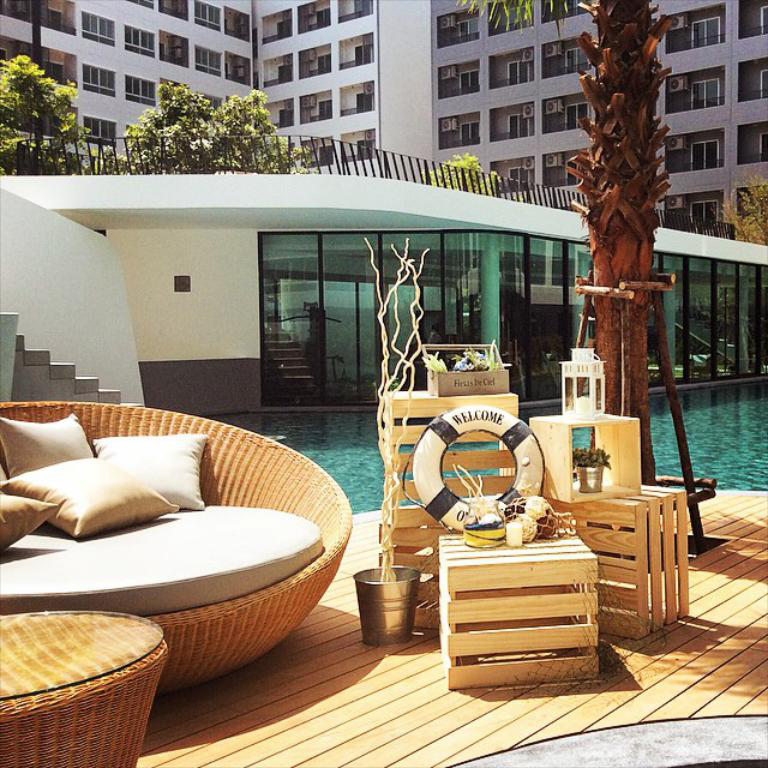

In [58]:
from PIL import Image
import io

jpg = Image.open(io.BytesIO(apd.data[0]))
jpg

## But I want some other Image

### `row_number` to add a new column with a one-up counter in it
### how/why this works is more advanced, but this is a useful tool sometimes.

In [59]:
from pyspark.sql import Window 
from pyspark.sql import functions as F

w = Window.partitionBy("source").orderBy('id')
flower_data = flower_data.withColumn('rnum', 
                                         F.row_number().over(Window.partitionBy("source").orderBy('id')))


## Then Filter to a number

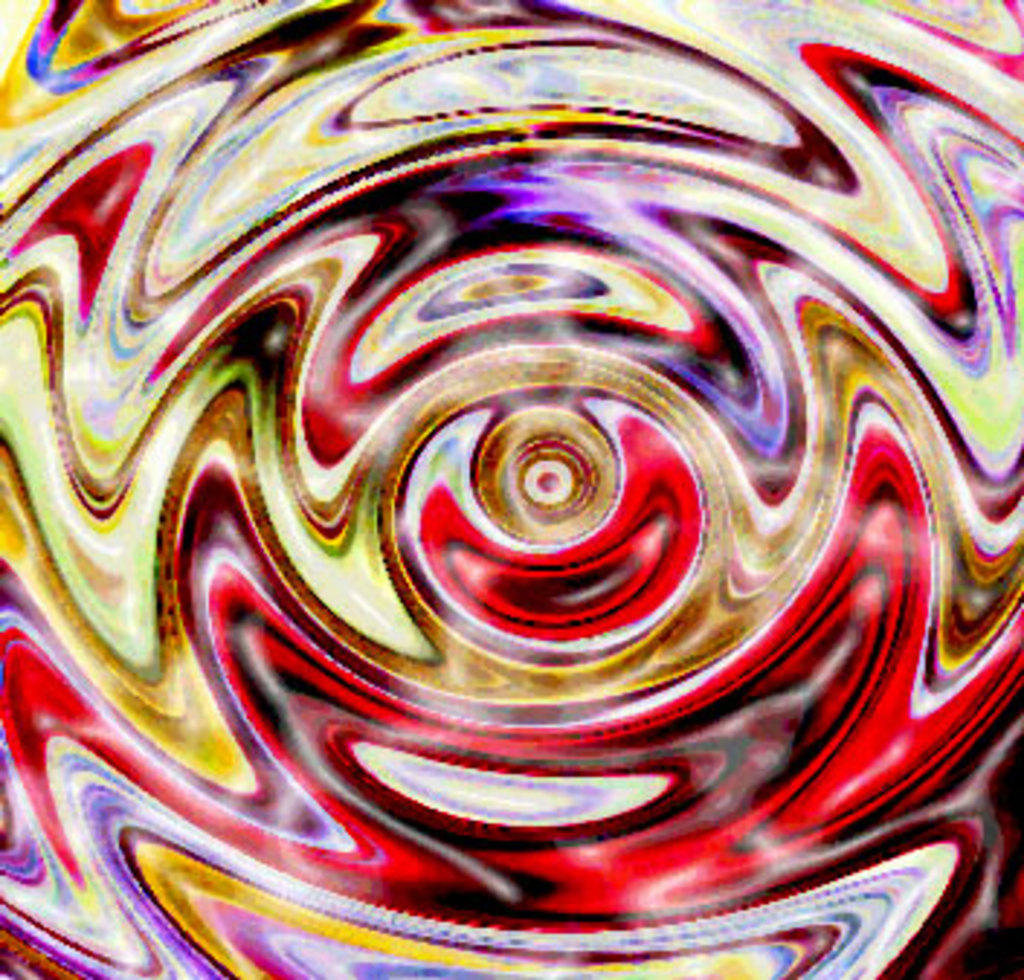

In [60]:
from PIL import Image
import io

apd = flower_data.filter('rnum = 814').collect()

jpg = Image.open(io.BytesIO(apd[0].data))
jpg

In [61]:
apd[0].Confidence

0.0

# Process All Images

## You can't bring all the images back from cluster...

## To Process All the Images, Need To Pass a Function to Worker Nodes

Notice in the function, how I'm importing libraries inside the function. This is necessary because the function is serialized and run in the worker environment without any other setup. To use a library in you function, it must be in the virtual environment archive created before launching Spark.

In [62]:
def calc_entropy(image_data):
    """
    Calculate entropy of an image. Approximates how homogenious an image is.
    """
    from PIL import Image
    import io
    
    jpg = Image.open(io.BytesIO( image_data ))
    return jpg.entropy()

## User Defined Functions (UDFs)

### the `udf` function takes a local function and packages it for us across the cluster

In [63]:
import pyspark.sql.functions as F

# package function into UDF
udf_entropy = F.udf(calc_entropy)

# Apply function to 'data' column for 
flower_data = flower_data.withColumn("entropy", udf_entropy('data'))


## Evaluate the Calculated Entropy

In [64]:
flower_data.select('entropy').summary().show()

Py4JJavaError: An error occurred while calling o1202.summary.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 111.0 failed 4 times, most recent failure: Lost task 2.3 in stage 111.0 (TID 3390, worker3.hdp-internal, executor 21): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 342, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 331, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 80, in <lambda>
    return lambda *a: f(*a)
  File "/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-62-9da22b7b9e4d>", line 5, in calc_entropy
ModuleNotFoundError: No module named 'PIL'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage7.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$11$$anon$1.hasNext(WholeStageCodegenExec.scala:624)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec$$anonfun$doExecute$1$$anonfun$2.apply(ObjectHashAggregateExec.scala:107)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec$$anonfun$doExecute$1$$anonfun$2.apply(ObjectHashAggregateExec.scala:105)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsWithIndexInternal$1$$anonfun$12.apply(RDD.scala:823)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsWithIndexInternal$1$$anonfun$12.apply(RDD.scala:823)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$11.apply(Executor.scala:407)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1363)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:413)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1890)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:929)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:929)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:929)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2111)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2049)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:740)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2081)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2102)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2121)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2146)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.sql.execution.stat.StatFunctions$.aggResult$lzycompute$1(StatFunctions.scala:273)
	at org.apache.spark.sql.execution.stat.StatFunctions$.org$apache$spark$sql$execution$stat$StatFunctions$$aggResult$1(StatFunctions.scala:273)
	at org.apache.spark.sql.execution.stat.StatFunctions$$anonfun$summary$2.apply$mcVI$sp(StatFunctions.scala:286)
	at scala.collection.immutable.Range.foreach$mVc$sp(Range.scala:160)
	at org.apache.spark.sql.execution.stat.StatFunctions$.summary(StatFunctions.scala:285)
	at org.apache.spark.sql.Dataset.summary(Dataset.scala:2533)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 342, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 331, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 80, in <lambda>
    return lambda *a: f(*a)
  File "/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-62-9da22b7b9e4d>", line 5, in calc_entropy
ModuleNotFoundError: No module named 'PIL'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage7.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$11$$anon$1.hasNext(WholeStageCodegenExec.scala:624)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec$$anonfun$doExecute$1$$anonfun$2.apply(ObjectHashAggregateExec.scala:107)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec$$anonfun$doExecute$1$$anonfun$2.apply(ObjectHashAggregateExec.scala:105)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsWithIndexInternal$1$$anonfun$12.apply(RDD.scala:823)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsWithIndexInternal$1$$anonfun$12.apply(RDD.scala:823)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$11.apply(Executor.scala:407)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1363)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:413)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


## See if Entropy affects Confidence

In [63]:
aa = flower_data.groupby('Confidence').agg(F.avg('entropy'))

aa.collect()

[Row(Confidence=0.0, avg(entropy)=8.109694293277151),
 Row(Confidence=1.0, avg(entropy)=8.290997385579244)]